<h1><center>CMPE 462 - Assignment 1Makeup <br>Implementing a Regression Tree<br>Due: April 16, 2023, 23:59</center></h1>

# Introduction

In this homework, you will implement a regression tree for continous target. The goal is to predict the house prices. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset). **Please use the train and test matrices we prepared for you.**

In [116]:
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

In [117]:
boston = load_boston()
X_y = np.column_stack([boston['data'], boston['target']])
np.random.seed(1)
np.random.shuffle(X_y)
X, y = X_y[:,:-1], X_y[:,-1]
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]
del X, y, X_y

C:\Users\kubra\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

**(10 pts)** Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

In [118]:
y_train = y_train.reshape(-1, 1)

data_train = np.concatenate((X_train, y_train), axis = 1)

In [119]:
corr_matrix = np.corrcoef(data_train, rowvar = False)

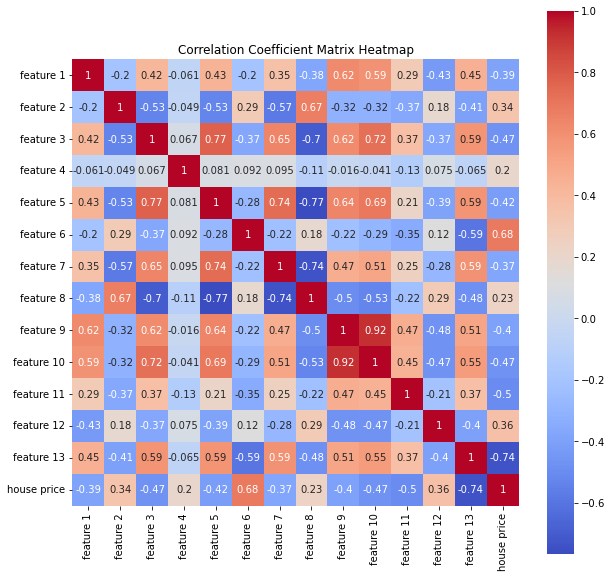

In [120]:
fig, ax = plt.subplots(figsize = (10, 10))

sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', square = True, ax = ax,
            xticklabels = [f"feature {i}" for i in range(1, 14)] + ["house price"],
            yticklabels = [f"feature {i}" for i in range(1, 14)] + ["house price"])
ax.set_title("Correlation Coefficient Matrix Heatmap")
plt.show()

We see that feature 13 and feature 6 have a strong correlation with house price.

## (80 pts) Task 2: Regression Tree


**(15 pts)** Now please build the regression tree. Start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

In [121]:
def possible_splits(x):
    return np.unique(x)[1:]

In [122]:
def rss_score(x, y, split):
    left_mask = x <= split
    right_mask = x > split
    y_left = y[left_mask]
    y_right = y[right_mask]
    rss_left = np.sum((y_left - np.mean(y_left))**2)
    rss_right = np.sum((y_right - np.mean(y_right))**2)
    rss_total = rss_left + rss_right
    return rss_total

In [123]:
def rss_score_for_every_possible_split(x):  
    rss_scores = []
    for i in range(0, len(possible_splits(x))):
        y = data_train[:, 13]
        rss_scores.append(rss_score(x, y, possible_splits(x)[i]))
    return possible_splits(x), rss_scores

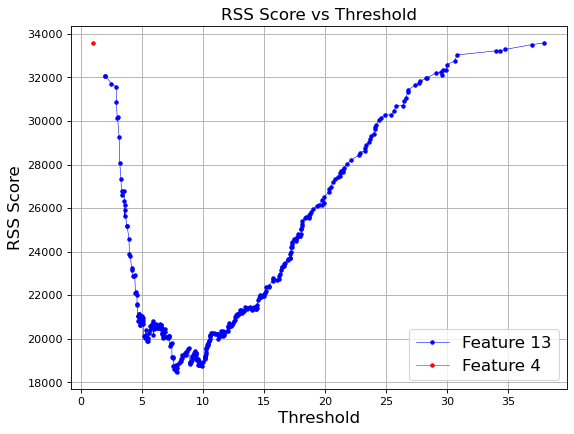

In [124]:
splits13, rss_scores13 = rss_score_for_every_possible_split(X_train[:, 12])
splits4, rss_scores4 = rss_score_for_every_possible_split(X_train[:, 3])

plt.figure(figsize = (8, 6), dpi = 80)
plt.plot(splits13, rss_scores13, '-o', markersize = 3, linewidth = 0.5, label = 'Feature 13', color = 'blue')
plt.plot(splits4, rss_scores4, '-o', markersize = 3, linewidth = 0.5, label = 'Feature 4', color = 'red')
plt.legend(loc = 'lower right', fontsize = 15)
plt.grid(True)
plt.xlabel("Threshold", fontsize = 15)
plt.ylabel("RSS Score", fontsize = 15)
plt.title("RSS Score vs Threshold" , fontsize = 15)
plt.show()

Feature 4 only has one threshold value and therefore one RSS value because it consists of only 0s and 1s. Feature 13 shows a strong distribution.

**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

In [125]:
def find_bests(X_train, y_train):
    best_feature, best_threshold, min_rss = None, None, np.inf
    for i in range(0, X_train.shape[1]):
        thresholds = possible_splits(X_train[:, i])
        for t in thresholds:
            rss = rss_score(X_train[:, i], y_train, t)
            if rss < min_rss:
                min_rss = rss
                best_threshold = t 
                best_feature = i + 1
    return {'feature': best_feature, 'threshold': best_threshold}

In [126]:
def split(X_train, y_train, depth, max_depth):
    if depth == max_depth or len(X_train) < 2:
        return {'prediction': np.mean(y_train)}
    
    rule = find_bests(X_train, y_train)
    left_ix = X_train[:, rule['feature'] - 1] < rule['threshold']
    rule['left'] = split(X_train[left_ix], y_train[left_ix], depth + 1, max_depth)
    rule['right'] = split(X_train[~left_ix], y_train[~left_ix], depth + 1, max_depth)
    return rule

**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

In [127]:
def predict(sample, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample[feature - 1] < rules['threshold']:
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
    return prediction

**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

In [128]:
split(X_train, y_train, 0, 3)

C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'feature': 13,
 'threshold': 7.85,
 'left': {'feature': 6,
  'threshold': 7.42,
  'left': {'feature': 8,
   'threshold': 1.3567,
   'left': {'prediction': 50.0},
   'right': {'prediction': 28.022772277227716}},
  'right': {'feature': 11,
   'threshold': 18.0,
   'left': {'prediction': 47.0},
   'right': {'prediction': 35.96666666666667}}},
 'right': {'feature': 13,
  'threshold': 14.98,
  'left': {'feature': 8,
   'threshold': 1.2852,
   'left': {'prediction': 50.0},
   'right': {'prediction': 21.46158940397351}},
  'right': {'feature': 5,
   'threshold': 0.655,
   'left': {'prediction': 17.118181818181817},
   'right': {'prediction': 12.106153846153846}}}}

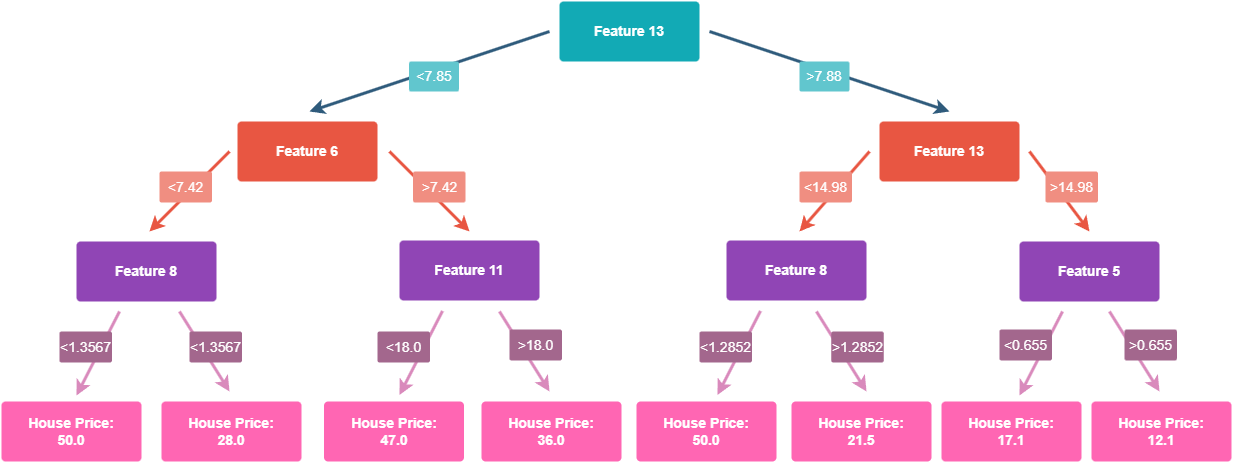

In [129]:
from IPython.display import Image
Image(filename='Cmpe462RegressionTree.drawio.png')

## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [130]:
def evaluate(X, y, rules):
    preds = []
    for i in range(0, len(X)):
        preds.append(predict(X[i], rules))
    return r2_score(preds, y)

In [131]:
num_folds = 5
np.random.shuffle(data_train)
fold_size = len(data_train) // num_folds
folds = []
for i in range(num_folds):
    start_idx = i * fold_size
    end_idx = (i + 1) * fold_size
    fold_data = data_train[start_idx:end_idx]
    folds.append(fold_data)

In [174]:
train_scores = [[], [], [], [], [], [], [], [], [], [], []]
test_scores = [[], [], [], [], [], [], [], [], [], [], []]
def performance(max_depth):

    for i in range(0, len(folds)):
        data = np.delete(folds, i, axis = 0)
        data_train = np.concatenate((data[0], data[1], data[2], data[3]), axis = 0)
        x_train = np.delete(data_train, 13, axis = 1)
        y_train = data_train[:, 13]
        data_test = folds[i]
        x_test = np.delete(data_test, 13, axis = 1)
        y_test = data_test[:, 13]
        rules = split(x_train, y_train, 0, max_depth)
        train_r2 = evaluate(x_train, y_train, rules)
        test_r2 = evaluate(x_test, y_test, rules)
        train_scores[max_depth].append(train_r2)
        test_scores[max_depth].append(test_r2)
        print('Max Depth', max_depth, 'Training R2:', train_r2, 'Test R2:',test_r2)

In [175]:
for max_depth in range(3, 11):
    performance(max_depth)

C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 3 Training R2: 0.7343599404902958 Test R2: 0.7978695238634742
Max Depth 3 Training R2: 0.7443407436235288 Test R2: 0.5759944057755294
Max Depth 3 Training R2: 0.7033129450297483 Test R2: 0.7399964919810117


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 3 Training R2: 0.7255083944935128 Test R2: 0.7237359916158412


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 3 Training R2: 0.7760205939876652 Test R2: 0.04623855006255495


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 4 Training R2: 0.8187623672504094 Test R2: 0.8310063177912252


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 4 Training R2: 0.840529695523796 Test R2: 0.577624920986245
Max Depth 4 Training R2: 0.8229101991528696 Test R2: 0.7963808069972238


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 4 Training R2: 0.8374533007618021 Test R2: 0.7999259894590804


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 4 Training R2: 0.8746181278194408 Test R2: 0.18274467757351776


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 5 Training R2: 0.886042611728329 Test R2: 0.8212904240792621


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 5 Training R2: 0.9063327670830875 Test R2: 0.6230309130652584


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 5 Training R2: 0.8866707243937595 Test R2: 0.8261494416919793


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 5 Training R2: 0.8781918644374594 Test R2: 0.8185176120445139


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 5 Training R2: 0.9057444209987567 Test R2: 0.26450692551119237


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 6 Training R2: 0.9205463155477148 Test R2: 0.8701861174949048


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 6 Training R2: 0.9320620396679187 Test R2: 0.6347165425984742


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 6 Training R2: 0.925647359828127 Test R2: 0.840862651798828


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 6 Training R2: 0.921882617529725 Test R2: 0.8485129912370131


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 6 Training R2: 0.9380752793614286 Test R2: 0.34569693266133017


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 7 Training R2: 0.9451159115139129 Test R2: 0.87152198165304


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 7 Training R2: 0.9496565685696654 Test R2: 0.6267155948204407


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 7 Training R2: 0.9455127943473485 Test R2: 0.8584630474882122


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 7 Training R2: 0.9491532628512583 Test R2: 0.823805656835712


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 7 Training R2: 0.9592682720083866 Test R2: 0.355179721193462


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 8 Training R2: 0.9629292912933531 Test R2: 0.8542000397483328


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 8 Training R2: 0.9678098337093523 Test R2: 0.6073669601307938


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 8 Training R2: 0.9616232365527456 Test R2: 0.8442071116648593


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 8 Training R2: 0.962820107252784 Test R2: 0.8197120133915712


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 8 Training R2: 0.9779693387107585 Test R2: 0.3624439989815992


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 9 Training R2: 0.9770483626550266 Test R2: 0.8523465496842182


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 9 Training R2: 0.9778768877650805 Test R2: 0.5974455925422387


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 9 Training R2: 0.974061604555842 Test R2: 0.8427353397257011


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 9 Training R2: 0.9740296404149837 Test R2: 0.8147289129960763


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 9 Training R2: 0.9848783876795012 Test R2: 0.4012201816267934


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 10 Training R2: 0.987080525764735 Test R2: 0.8464481856308942


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 10 Training R2: 0.9874190358710201 Test R2: 0.6051482584522075


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 10 Training R2: 0.9816124555301361 Test R2: 0.8458139240763228


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 10 Training R2: 0.9818415759481143 Test R2: 0.8152890709422196


C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\kubra\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Max Depth 10 Training R2: 0.990342658408606 Test R2: 0.3897316933337466


In [178]:
for i in range(3, 11):
    train_mean = np.mean(train_scores[i])
    train_std = np.std(train_scores[i])
    test_mean = np.mean(test_scores[i])
    test_std = np.std(test_scores[i])
   
    print('For depth', i, 'Train R2 mean:', train_mean, 'Test R2 mean:', test_mean)
    print('For depth', i, 'Train R2 std:', train_std, 'Test R2 std:', test_std)   

For depth 3 Train R2 mean: 0.7367085235249501 Test R2 mean: 0.5767669926596823
For depth 3 Train R2 std: 0.02387430863216492 Test R2 std: 0.27516944259950743
For depth 4 Train R2 mean: 0.8388547381016636 Test R2 mean: 0.6375365425614585
For depth 4 Train R2 std: 0.01970645194753772 Test R2 std: 0.24472737059605423
For depth 5 Train R2 mean: 0.8925964777282784 Test R2 mean: 0.6706990632784412
For depth 5 Train R2 std: 0.011376419943617164 Test R2 std: 0.2172359117571205
For depth 6 Train R2 mean: 0.9276427223869828 Test R2 mean: 0.70799504715811
For depth 6 Train R2 std: 0.006570964617024431 Test R2 std: 0.20016727967704281
For depth 7 Train R2 mean: 0.9497413618581143 Test R2 mean: 0.7071372003981734
For depth 7 Train R2 std: 0.00510667487578305 Test R2 std: 0.19691373687230723
For depth 8 Train R2 mean: 0.9666303615037988 Test R2 mean: 0.6975860247834313
For depth 8 Train R2 std: 0.006053937846048791 Test R2 std: 0.190473151378658
For depth 9 Train R2 mean: 0.9775789766140868 Test R2 

For depth 10, the R2 value is higher and has lower standard deviation.

**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

In [181]:
boston = load_boston()
X_y = np.column_stack([boston['data'], boston['target']])
np.random.seed(1)
np.random.shuffle(X_y)
X, y = X_y[:,:-1], X_y[:,-1]
X_train, y_train = X[:400], y[:400]
X_test, y_test = X[400:], y[400:]
del X, y, X_y

In [182]:
split(X_train, y_train, 0, 10)

{'feature': 13,
 'threshold': 7.85,
 'left': {'feature': 6,
  'threshold': 7.42,
  'left': {'feature': 8,
   'threshold': 1.3567,
   'left': {'feature': 1,
    'threshold': 6.53876,
    'left': {'prediction': 50.0},
    'right': {'prediction': 50.0}},
   'right': {'feature': 6,
    'threshold': 6.538,
    'left': {'feature': 8,
     'threshold': 6.27,
     'left': {'feature': 10,
      'threshold': 254.0,
      'left': {'feature': 6,
       'threshold': 6.24,
       'left': {'prediction': 25.3},
       'right': {'feature': 1,
        'threshold': 0.16211,
        'left': {'prediction': 28.7},
        'right': {'prediction': 25.2}}},
      'right': {'feature': 2,
       'threshold': 30.0,
       'left': {'feature': 12,
        'threshold': 354.7,
        'left': {'feature': 1,
         'threshold': 1.34284,
         'left': {'prediction': 27.0},
         'right': {'prediction': 24.3}},
        'right': {'feature': 1,
         'threshold': 4.54192,
         'left': {'feature': 6,
       

In [185]:
max_depth = 10
rules = split(X_train, y_train, 0, max_depth)
train_r2 = evaluate(X_train, y_train, rules)
test_r2 = evaluate(X_test, y_test, rules)
print('Max Depth', max_depth, 'Training R2:', train_r2, 'Test R2:',test_r2)

Max Depth 10 Training R2: 0.9740097590255414 Test R2: 0.8797352473169215
